In [1]:
import polars as pl
from pathlib import Path
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime, time

# Define project root
PROJECT_ROOT = Path("e:/miso-load-forecasting").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PLOT_DIR = PROJECT_ROOT / "plots"

# Verify directories exist
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Contents: {[x.name for x in DATA_DIR.iterdir() if x.is_dir()]}")

Project root: E:\miso-load-forecasting
Data directory: E:\miso-load-forecasting\data
Contents: ['miso_load_actual', 'miso_load_forecast', 'weather_kmsp', 'miso_nodes', 'miso_lmp_rt_expost_original', 'miso_lmp_da_expost_original', 'miso_lmp_da_exante_original', 'miso_da_cleared_generation_virtual', 'miso_da_cleared_generation_phys', 'miso_da_cleared_demand', 'miso_da_fuel_mix', 'miso_rt_fuel_mix', 'miso_lmp_da_expost', 'miso_lmp_da_expost - Copy', 'miso_rt_fuel_mix - Copy', 'miso_da_fuel_mix - Copy', 'miso_lmp_rt_expost', 'miso_lmp_da_exante', 'ftr', 'combined_analysis']


In [2]:
## read in combined analysis dataset
final_pdf = pl.read_parquet(DATA_DIR / "combined_analysis" / "miso_full_analysis_dataset.parquet").to_pandas()
final_pdf.head()

,node,start_time,lmp_da_exante,node_right,start_time_right,lmp_rt_expost,lmp_dart_spread,month,year,day_of_week,...,WindMW_PctDiff,SolarMW_PctDiff,NuclearMW_PctDiff,WindMissFlag,GasMissFlag,LowWindFlag,LowGasFlag,GasMissLabel,WindMW_RT_PctOfSeasonalAvg,lmp_da_expost
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05,GRE.ALTW.ENDVI,2014-12-01 00:00:00,16.34,-0.71,12.0,2014.0,1.0,...,1.193290,1.466667,0.997448,0.0,0.0,0.0,1.0,Hit,82.03,17.05
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 01:00:00,18.40,0.53,12.0,2014.0,1.0,...,1.177524,1.833333,0.980408,0.0,0.0,0.0,1.0,Hit,78.32,17.87
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 02:00:00,18.04,0.17,12.0,2014.0,1.0,...,1.156237,1.400000,0.930283,0.0,0.0,0.0,1.0,Hit,74.99,17.87
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07,GRE.ALTW.ENDVI,2014-12-01 03:00:00,20.00,2.93,12.0,2014.0,1.0,...,1.058169,0.900000,0.890753,0.0,0.0,0.0,1.0,Hit,65.43,17.07
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53,GRE.ALTW.ENDVI,2014-12-01 04:00:00,21.24,1.71,12.0,2014.0,1.0,...,0.989435,1.400000,0.882147,0.0,0.0,0.0,1.0,Hit,58.17,19.53


In [3]:
## columns in final_pdf
print(final_pdf.columns)

Index(['node', 'start_time', 'lmp_da_exante', 'node_right', 'start_time_right',
       'lmp_rt_expost', 'lmp_dart_spread', 'month', 'year', 'day_of_week',
       'date', 'regime', 'consecutive_regime_hours', 'hours_since_extreme',
       'hours_since_scarcity', 'Temperature', 'WindSpeed',
       'WindSpeedVolatility6h', 'TemperatureBucket', 'Period', 'TotalMW_DA',
       'CoalMW_DA', 'GasMW_DA', 'WindMW_DA', 'SolarMW_DA', 'NuclearMW_DA',
       'TotalMW_RT', 'CoalMW_RT', 'GasMW_RT', 'WindMW_RT', 'SolarMW_RT',
       'NuclearMW_RT', 'TotalMW_Diff', 'CoalMW_Diff', 'GasMW_Diff',
       'WindMW_Diff', 'SolarMW_Diff', 'NuclearMW_Diff', 'TotalMW_PctDiff',
       'CoalMW_PctDiff', 'GasMW_PctDiff', 'WindMW_PctDiff', 'SolarMW_PctDiff',
       'NuclearMW_PctDiff', 'WindMissFlag', 'GasMissFlag', 'LowWindFlag',
       'LowGasFlag', 'GasMissLabel', 'WindMW_RT_PctOfSeasonalAvg',
       'lmp_da_expost'],
      dtype='object')


In [4]:
## with final_pdf make dataframe for source nodes
## select node, start_time, lmp_da_expost, year, month, day_of_week, regime, Temperature, WindSpeed, TemperatureBucket, GasMW_PctDiff, WindMW_RT_PctOfSeasonalAvg
source_nodes_df = final_pdf[["node", "start_time", "lmp_da_expost", 
                             "year", "month", "day_of_week", "regime", 
                             "Temperature", "WindSpeed", "TemperatureBucket", 
                             "GasMW_PctDiff", "WindMW_RT_PctOfSeasonalAvg"]].copy()
## column for hour_of_day
source_nodes_df["hour_of_day"] = source_nodes_df["start_time"].dt.hour
## column for day of month
source_nodes_df["day_of_month"] = source_nodes_df["start_time"].dt.day
## rename node to source and lmp_da_expost to lmp
source_nodes_df.rename(columns={"node": "Source", "lmp_da_expost": "lmp"}, inplace=True)
source_nodes_df.head()

,Source,start_time,lmp,year,month,day_of_week,regime,Temperature,WindSpeed,TemperatureBucket,GasMW_PctDiff,WindMW_RT_PctOfSeasonalAvg,hour_of_day,day_of_month
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05,2014.0,12.0,1.0,Normal Operations,3.9,10.2,Very Cold,0.978788,82.03,0.0,1.0
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87,2014.0,12.0,1.0,Normal Operations,3.8,10.6,Very Cold,1.013904,78.32,1.0,1.0
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87,2014.0,12.0,1.0,Normal Operations,3.9,11.5,Very Cold,1.206560,74.99,2.0,1.0
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07,2014.0,12.0,1.0,Normal Operations,3.8,12.3,Very Cold,1.211297,65.43,3.0,1.0
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53,2014.0,12.0,1.0,Normal Operations,3.2,12.2,Very Cold,1.413627,58.17,4.0,1.0


In [5]:
## function to define peak and offpeak hours
def define_peak_offpeak(df):
    ## if christmas or new years day, return offpeak 
    ## (only NERC holidays for winter season)
    if (df["month"] == 12 and df["day_of_month"] == 25) or (df["month"] == 1 and df["day_of_month"] == 1):
        return "Off-peak"
    ## if weekend, return offpeak
    if df["day_of_week"] in [5, 6]:
        return "Off-peak"
    ## if start_time hour between 0600 and 2100 EST, return peak
    if 6 <= df["hour_of_day"] < 22:
        return "Peak"
    else:
        return "Off-peak"
## apply function to dataframe of datetimes from December to February from 2014 to 2025
date_range = pd.date_range(start='2014-12-01', end='2026-03-01', freq='H')
date_range_df = pd.DataFrame(date_range, columns=["start_time"])
date_range_df["month"] = date_range_df["start_time"].dt.month
date_range_df["day_of_month"] = date_range_df["start_time"].dt.day
date_range_df["day_of_week"] = date_range_df["start_time"].dt.dayofweek
date_range_df["hour_of_day"] = date_range_df["start_time"].dt.hour
## add season column based on december year for each winter season
date_range_df["WinterYear"] = date_range_df["start_time"].dt.year
date_range_df.loc[date_range_df["month"].isin([1, 2]), "WinterYear"] -= 1
## filter to only include months 12, 1, 2
date_range_df = date_range_df[date_range_df["month"].isin([12, 1, 2])].copy()
## apply define_peak_offpeak function
date_range_df["Class"] = date_range_df.apply(define_peak_offpeak, axis=1)
## sum number of peak and offpeak hours as a dataframe by Class and year
peak_offpeak_hours_df = date_range_df.groupby(["WinterYear", "Class"]).size().reset_index(name="ClassHours")
## apply function to source_nodes_df
source_nodes_df["Class"] = source_nodes_df.apply(define_peak_offpeak, axis=1)
## add WinterYear column to source_nodes_df
source_nodes_df["WinterYear"] = source_nodes_df["start_time"].dt.year
source_nodes_df.loc[source_nodes_df["month"].isin([1, 2]), "WinterYear"] -= 1
## merge peak_offpeak_hours_df to source_nodes_df on year and Class
source_nodes_df = source_nodes_df.merge(peak_offpeak_hours_df, on=["WinterYear", "Class"], how="left")
source_nodes_df.head()

C:\Users\legion\AppData\Local\Temp\ipykernel_12284\2556544414.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2014-12-01', end='2026-03-01', freq='H')


,Source,start_time,lmp,year,month,day_of_week,regime,Temperature,WindSpeed,TemperatureBucket,GasMW_PctDiff,WindMW_RT_PctOfSeasonalAvg,hour_of_day,day_of_month,Class,WinterYear,ClassHours
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05,2014.0,12.0,1.0,Normal Operations,3.9,10.2,Very Cold,0.978788,82.03,0.0,1.0,Off-peak,2014.0,1152.0
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87,2014.0,12.0,1.0,Normal Operations,3.8,10.6,Very Cold,1.013904,78.32,1.0,1.0,Off-peak,2014.0,1152.0
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87,2014.0,12.0,1.0,Normal Operations,3.9,11.5,Very Cold,1.206560,74.99,2.0,1.0,Off-peak,2014.0,1152.0
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07,2014.0,12.0,1.0,Normal Operations,3.8,12.3,Very Cold,1.211297,65.43,3.0,1.0,Off-peak,2014.0,1152.0
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53,2014.0,12.0,1.0,Normal Operations,3.2,12.2,Very Cold,1.413627,58.17,4.0,1.0,Off-peak,2014.0,1152.0


In [6]:
## sink node dataframe just node, start_time, lmp_da_expost
sink_nodes_df = final_pdf[["node", "start_time", "lmp_da_expost"]].copy()
## rename node to sink and lmp_da_expost to lmp
sink_nodes_df.rename(columns={"node": "Sink", "lmp_da_expost": "lmp"}, inplace=True)
sink_nodes_df.head()

,Sink,start_time,lmp
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53


In [7]:
## read in FTR auction results csv
## loop through 3 rounds from 2023 to 2025 annual auction and append to single dataframe
for round_num in [1, 2, 3]:
    for year_num in [23, 24, 25]:
        file_path = DATA_DIR / "ftr" / f"MarketResults_Win{year_num}_AUCTION_Annual{year_num}Auc_Round_{round_num}.csv"
        round_pdf = pl.read_csv(file_path).to_pandas()
        if round_num == 1 and year_num == 23:
            ftr_auction_pdf = round_pdf
        else:
            ftr_auction_pdf = pd.concat([ftr_auction_pdf, round_pdf], ignore_index=True)
## filter to MarketParticipant == 'GREM' 
ftr_auction_pdf = ftr_auction_pdf[ftr_auction_pdf["MarketParticipant"] == "GREM"]
## summarize positions by Source, Sink, StartDate, EndDate, Class, MW, ClearingPrice
## sum of MW and weighted average of ClearingPrice by MW
ftr_auction_pdf = ftr_auction_pdf.groupby(["Source", "Sink", "StartDate", "EndDate", "Type", "Class"]).apply(
    lambda x: pd.Series({
        "MW": x["MW"].sum(),
        "ClearingPrice": np.average(x["ClearingPrice"], weights=x["MW"])
    })
).reset_index()
## order by MW descending
ftr_auction_pdf = ftr_auction_pdf.sort_values(by="MW", ascending=False).reset_index(drop=True)
## extract WinterYear from StartDate
ftr_auction_pdf["WinterYear"] = pd.to_datetime(ftr_auction_pdf["StartDate"]).dt.year
## for 2014 to 2022 no ftr data avaialable, so use the 2025 auction data as what if analysis for those years
## filter to 2025 only
fill_auction_pdf = ftr_auction_pdf[ftr_auction_pdf["WinterYear"] == 2025].copy()
for year in range(2014, 2022):
    temp_pdf = fill_auction_pdf.copy()
    temp_pdf["WinterYear"] = year
    temp_pdf["StartDate"] = temp_pdf["StartDate"].str.replace("2025", str(year))
    temp_pdf["EndDate"] = temp_pdf["EndDate"].str.replace("2026", str(year + 1))
    ftr_auction_pdf = pd.concat([ftr_auction_pdf, temp_pdf], ignore_index=True)
## display head
ftr_auction_pdf.head(10)

C:\Users\legion\AppData\Local\Temp\ipykernel_12284\2375979759.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ftr_auction_pdf = ftr_auction_pdf.groupby(["Source", "Sink", "StartDate", "EndDate", "Type", "Class"]).apply(


,Source,Sink,StartDate,EndDate,Type,Class,MW,ClearingPrice,WinterYear
0,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023
1,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Peak,218.1,856.179762,2023
2,GRE.REC.CC2_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Peak,218.0,856.175477,2023
3,GRE.REC.CC2_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.0,834.897904,2023
4,GRE.REC.CC1_DC,GRE.AZ,12/01/2024,02/28/2025,BUY,Peak,215.1,2173.783333,2024
5,GRE.REC.CC1_DC,GRE.AZ,12/01/2024,02/28/2025,BUY,Off-peak,215.1,2584.403333,2024
6,GRE.REC.CC2_DC,GRE.AZ,12/01/2024,02/28/2025,BUY,Peak,207.2,2173.619199,2024
7,GRE.REC.CC2_DC,GRE.AZ,12/01/2024,02/28/2025,BUY,Off-peak,207.2,2584.200280,2024
8,GRE.REC.CC1_DC,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,199.4,1694.519047,2025
9,MINN.HUB,GRE.NSP.GREC,12/01/2025,02/28/2026,BUY,Peak,197.1,-128.672577,2025


In [8]:
## create merged dataframe joining source_nodes_df, sink_nodes_df, and ftr_auction_pdf
## first merge auction results with source_nodes_df on Source and Class
merged_df = pd.merge(ftr_auction_pdf, source_nodes_df, left_on=["Source", "Class", "WinterYear"], right_on=["Source", "Class", "WinterYear"], how="inner")
## then merge with sink_nodes_df on Sink and start_time and name lmp from sink_nodes_df as lmp_sink and lmp from source_nodes_df as lmp_source
merged_df = pd.merge(merged_df, sink_nodes_df, left_on=["Sink", "start_time"], right_on=["Sink", "start_time"], how="inner", suffixes=("_source", "_sink"))
merged_df.rename(columns={"lmp_source": "lmp_source", "lmp_sink": "lmp_sink"}, inplace=True)
## filter to winter months december, january, february
merged_df = merged_df[merged_df["month"].isin([12, 1, 2])].copy()
## display head
merged_df.head()

,Source,Sink,StartDate,EndDate,Type,Class,MW,ClearingPrice,WinterYear,start_time,...,regime,Temperature,WindSpeed,TemperatureBucket,GasMW_PctDiff,WindMW_RT_PctOfSeasonalAvg,hour_of_day,day_of_month,ClassHours,lmp_sink
3432,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023,2023-12-01 00:00:00,...,Normal Operations,26.8,4.0,Cold,0.716722,157.62,0.0,1.0,1176.0,34.77
3433,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023,2023-12-01 01:00:00,...,Normal Operations,26.5,6.4,Cold,0.780990,156.77,1.0,1.0,1176.0,31.96
3434,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023,2023-12-01 02:00:00,...,Normal Operations,25.1,6.4,Cold,0.813811,158.08,2.0,1.0,1176.0,29.87
3435,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023,2023-12-01 03:00:00,...,Normal Operations,23.9,5.5,Cold,0.806873,164.04,3.0,1.0,1176.0,28.74
3436,GRE.REC.CC1_DC,GRE.AZ,12/01/2023,02/29/2024,BUY,Off-peak,218.1,835.136034,2023,2023-12-01 04:00:00,...,Normal Operations,23.2,4.4,Cold,0.873121,162.59,4.0,1.0,1176.0,29.54


In [11]:
def calculate_ftr_hourly_profitability(ftr_data, hourly_lmp_data):
    """
    Calculate hourly FTR profitability

    Parameters:
    -----------
    ftr_data: DataFrame with columns [Source, Sink, StartDate, EndDate, 
                                      Class, MW, ClearingPrice, lmp_source, lmp_sink]
    Returns:
    --------
    Tuple of (summary_df, ftr_data)
    - summary_df: Overall profitability metrics for each FTR
    - ftr_data: Adds hourly profit/loss details for each FTR
    """
    ## calculate price spread
    ftr_data["PriceSpread"] = ftr_data["lmp_sink"] - ftr_data["lmp_source"]
    ## calculate hourly cost of FTR
    ftr_data["HourlyCost"] = ftr_data["ClearingPrice"] * ftr_data["MW"] / ftr_data["ClassHours"]
    ## calculate hourly profit/loss
    ftr_data["HourlyProfitLoss"] = ftr_data["PriceSpread"] * ftr_data["MW"] - ftr_data["HourlyCost"]
    ## calculate total cost of FTR
    ftr_data["TotalCost"] = ftr_data["ClearingPrice"] * ftr_data["MW"]
    ## calculate hourly congestion revenue
    ftr_data["HourlyCongestionRevenue"] = ftr_data["PriceSpread"] * ftr_data["MW"]
    ## calculate summary metrics for each FTR
    summary_df = ftr_data.groupby(["Source", "Sink", "Class", "WinterYear"]).agg(
        TotalCost=pd.NamedAgg(column="TotalCost", aggfunc="first"),
        PricePaidPerMW=pd.NamedAgg(column="ClearingPrice", aggfunc="first"),
        MWHeld=pd.NamedAgg(column="MW", aggfunc="first"),
        TotalCongestionRevenue=pd.NamedAgg(column="HourlyCongestionRevenue", aggfunc="sum"),
        TotalProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc="sum"),
        AvgHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc="mean"),
        StdHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc="std"),
        SkewnessHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc=lambda x: stats.skew(x, bias=False)),
        KurtosisHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc=lambda x: stats.kurtosis(x, bias=False)),
        MaxHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc="max"),
        MinHourlyProfitLoss=pd.NamedAgg(column="HourlyProfitLoss", aggfunc="min")
    ).reset_index()
    return summary_df, ftr_data   

In [12]:
summary_df, detailed_ftr_df = calculate_ftr_hourly_profitability(merged_df, None)
summary_df.head(10)

,Source,Sink,Class,WinterYear,TotalCost,PricePaidPerMW,MWHeld,TotalCongestionRevenue,TotalProfitLoss,AvgHourlyProfitLoss,StdHourlyProfitLoss,SkewnessHourlyProfitLoss,KurtosisHourlyProfitLoss,MaxHourlyProfitLoss,MinHourlyProfitLoss
0,GRE.ALTW.ENDVI,GRE.AZ,Off-peak,2023,3439.327,8598.317500,0.4,5528.072,2112.141782,1.808341,5.091756,NaN,NaN,26.155402,-4.180598
1,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2014,257396.202,9160.007189,28.1,134902.761,-102831.231125,-96.645894,236.787395,NaN,NaN,1636.504797,-478.020203
2,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2015,257396.202,9160.007189,28.1,387580.209,149444.947286,137.357488,502.097952,NaN,NaN,1436.215679,-383.821321
3,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2016,257396.202,9160.007189,28.1,33202.679,-226006.172310,-197.557843,116.503693,NaN,NaN,317.996836,-1587.183164
4,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2017,257396.202,9160.007189,28.1,46486.111,-210910.091000,-180.573708,114.702937,-1.519467,13.769496,346.965539,-1112.548461
5,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2018,257396.202,9160.007189,28.1,65005.135,-188865.091630,-163.945392,118.457891,0.064464,5.042233,422.835539,-948.163461
6,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2019,257396.202,9160.007189,28.1,83861.921,-173534.281000,-147.563164,79.242336,2.034271,8.097525,453.558679,-304.298321
7,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2020,257396.202,9160.007189,28.1,277779.459,27435.207740,24.150711,403.210566,1.315925,1.112422,1332.432539,-1201.344461
8,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2021,257396.202,9160.007189,28.1,480460.263,226689.359620,202.401214,426.970221,NaN,NaN,1477.121836,-577.831164
9,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2023,226318.593,8199.949022,27.6,310142.580,97680.227388,88.478467,374.163001,NaN,NaN,1889.972217,-524.199783


In [ ]:
# Filter to specific event dates
winter_storm = detailed_ftr_df[
    (detailed_ftr_df['start_time'] >= '2026-01-21') & 
    (detailed_ftr_df['start_time'] <= '2026-01-26')
]

# Analyze performance during extreme weather
storm_profit = winter_storm.groupby(['Source', 'Sink', 'Class', 'WinterYear'])['HourlyProfitLoss'].sum()

# Compare to overall 2021 performance
print(f"Winter Storm profit: ${storm_profit.sum():,.2f}")


In [13]:
## summarize summary_df see min, max, total profit loss by year 
summary_by_year = summary_df.groupby('WinterYear').agg(
    TotalProfitLoss=pd.NamedAgg(column='TotalProfitLoss', aggfunc='sum'),
    MinProfitLoss=pd.NamedAgg(column='MinHourlyProfitLoss', aggfunc='min'),
    MaxProfitLoss=pd.NamedAgg(column='MaxHourlyProfitLoss', aggfunc='max'),
    MinTotalProfitLoss=pd.NamedAgg(column='TotalProfitLoss', aggfunc='min'),
    MaxTotalProfitLoss=pd.NamedAgg(column='TotalProfitLoss', aggfunc='max')
).reset_index()
summary_by_year.style.format({
    'TotalProfitLoss': '${:,.2f}',
    'MinProfitLoss': '${:,.2f}',
    'MaxProfitLoss': '${:,.2f}',
    'MinTotalProfitLoss': '${:,.2f}',
    'MaxTotalProfitLoss': '${:,.2f}'
})

,WinterYear,TotalProfitLoss,MinProfitLoss,MaxProfitLoss,MinTotalProfitLoss,MaxTotalProfitLoss
0,2014,"$-614,232.69",$-585.41,"$2,026.60","$-166,233.21","$42,647.22"
1,2015,"$-450,687.06","$-1,151.36","$1,436.22","$-178,948.32","$149,444.95"
2,2016,"$-1,435,036.96","$-1,587.18","$2,080.61","$-351,490.24","$43,228.89"
3,2017,"$-651,043.02","$-13,683.48","$6,138.12","$-210,910.09","$46,184.74"
4,2018,"$-601,499.82","$-1,514.40","$5,913.79","$-188,865.09","$22,483.54"
5,2019,"$-1,118,331.98","$-1,330.94","$1,744.22","$-173,534.28","$36,500.07"
6,2020,"$430,348.44","$-27,745.99","$8,934.43","$-489,738.13","$725,090.35"
7,2021,"$7,014,055.97","$-3,087.45","$6,865.77","$-161,842.69","$2,621,803.00"
8,2023,"$1,969,467.07","$-7,532.89","$7,437.18","$-221,123.30","$859,792.50"
9,2024,"$1,712,399.07","$-11,324.13","$5,615.87","$-270,058.77","$292,519.39"


In [14]:
# Filter to specific event dates
winter_storm = detailed_ftr_df[
    (detailed_ftr_df['start_time'] >= '2026-01-21') & 
    (detailed_ftr_df['start_time'] <= '2026-01-26')
]
## find biggest winners and losers during the storm
storm_summary = winter_storm.groupby(['Source', 'Sink', 'Class', 'WinterYear']).agg(
    TotalProfitLoss=pd.NamedAgg(column='HourlyProfitLoss', aggfunc='sum')   
).reset_index().sort_values(by='TotalProfitLoss', ascending=False)
storm_summary.style.format({
    'TotalProfitLoss': '${:,.2f}'
})
storm_summary.head(10)

,Source,Sink,Class,WinterYear,TotalProfitLoss
20,WAUE,GRE.AZ,Off-peak,2025,1.091970e+06
18,OTP.GRE.DEUEL,MINN.HUB,Off-peak,2025,4.215833e+05
14,NSP.GRE.BFRDG,MINN.HUB,Off-peak,2025,3.044879e+05
9,MDU.GRE.EMMLOG,MINN.HUB,Off-peak,2025,3.010365e+05
22,WAUE,OTP.GREM_2.AZ,Off-peak,2025,2.920536e+05
0,GRE.ALTW.ENDVI,MINN.HUB,Off-peak,2025,2.788514e+05
5,GRE.REC.CC1_DC,GRE.AZ,Off-peak,2025,2.254724e+05
2,GRE.LKFLGR1,GRE.AZ,Off-peak,2025,1.875829e+05
19,OTP.GRE.DEUEL,MINN.HUB,Peak,2025,1.019720e+05
21,WAUE,GRE.AZ,Peak,2025,7.821512e+04


In [20]:
waue_gre_ftr = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2025) & 
    (detailed_ftr_df['Class'] == 'Off-peak')
]
waue_gre_ftr.head()

,Source,Sink,StartDate,EndDate,Type,Class,MW,ClearingPrice,WinterYear,start_time,...,WindMW_RT_PctOfSeasonalAvg,hour_of_day,day_of_month,ClassHours,lmp_sink,PriceSpread,HourlyCost,HourlyProfitLoss,TotalCost,HourlyCongestionRevenue
73496,WAUE,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,55.6,3272.969209,2025,2025-12-01 00:00:00,...,30.52,0.0,1.0,1152.0,94.21,47.61,157.966222,2489.149778,181977.088,2647.116
73497,WAUE,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,55.6,3272.969209,2025,2025-12-01 01:00:00,...,33.91,1.0,1.0,1152.0,86.77,43.50,157.966222,2260.633778,181977.088,2418.600
73498,WAUE,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,55.6,3272.969209,2025,2025-12-01 02:00:00,...,36.50,2.0,1.0,1152.0,84.75,39.99,157.966222,2065.477778,181977.088,2223.444
73499,WAUE,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,55.6,3272.969209,2025,2025-12-01 03:00:00,...,37.77,3.0,1.0,1152.0,82.14,36.13,157.966222,1850.861778,181977.088,2008.828
73500,WAUE,GRE.AZ,12/01/2025,02/28/2026,BUY,Off-peak,55.6,3272.969209,2025,2025-12-01 04:00:00,...,40.60,4.0,1.0,1152.0,79.07,30.03,157.966222,1511.701778,181977.088,1669.668


In [21]:
157/55.6

2.8237410071942444

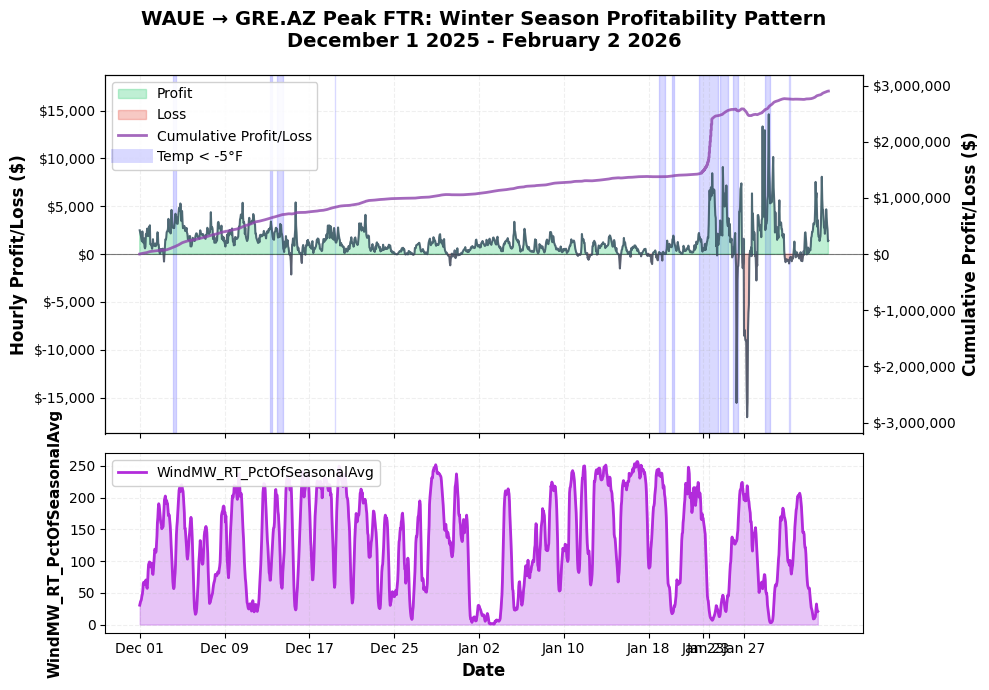


Correlation Analysis:
Temperature vs Profit: -0.255
Wind vs Profit: -0.391

FTR Performance Summary (Jan 21-26, 2026):
Total Profit/Loss: $2,902,737.15
Average Hourly: $1,511.84
Max Hourly Profit: $14,615.16
Max Hourly Loss: $-17,037.23
Profitable Hours: 1751 of 1920

Wind Output:
Average: 122.6% of seasonal average
Min: 0.8%
Max: 256.7%


In [22]:

## Filter data
waue_gre_ftr = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2025)
].sort_values('start_time').copy()

## top plot has left and right y-axes, bottom plot has single y-axis, shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, 
                                gridspec_kw={'height_ratios': [2, 1]})

## Top panel: Profit/Loss with cold period shading
# First, shade extreme cold regions (temp < -5°F)
cold_mask = waue_gre_ftr['Temperature'] < -5
cold_regions = []
in_cold = False
start_idx = None

for idx, is_cold in enumerate(cold_mask):
    if is_cold and not in_cold:
        start_idx = idx
        in_cold = True
    elif not is_cold and in_cold:
        cold_regions.append((start_idx, idx-1))
        in_cold = False
if in_cold:
    cold_regions.append((start_idx, len(cold_mask)-1))

# Shade cold periods
for start, end in cold_regions:
    ax1.axvspan(waue_gre_ftr.iloc[start]['start_time'], 
                waue_gre_ftr.iloc[end]['start_time'],
                alpha=0.15, color='blue', zorder=0)

# Plot profit/loss
ax1.fill_between(waue_gre_ftr['start_time'], 
                  waue_gre_ftr['HourlyProfitLoss'], 
                  0, 
                  where=(waue_gre_ftr['HourlyProfitLoss'] >= 0),
                  color='#2ecc71', alpha=0.3, label='Profit', zorder=2)
ax1.fill_between(waue_gre_ftr['start_time'], 
                  waue_gre_ftr['HourlyProfitLoss'], 
                  0, 
                  where=(waue_gre_ftr['HourlyProfitLoss'] < 0),
                  color='#e74c3c', alpha=0.3, label='Loss', zorder=2)
ax1.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['HourlyProfitLoss'], 
         color='#34495e', 
         linewidth=1.5, 
         alpha=0.8,
         zorder=3)
## left y-axis is centered at 0 with symmetric limits
ax1.set_ylim(-max(abs(waue_gre_ftr['HourlyProfitLoss'].min()), waue_gre_ftr['HourlyProfitLoss'].max()) * 1.1,
             max(abs(waue_gre_ftr['HourlyProfitLoss'].min()), waue_gre_ftr['HourlyProfitLoss'].max()) * 1.1)

## plot cumulative profit/loss on right y-axis
ax3 = ax1.twinx()
ax3.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['HourlyProfitLoss'].cumsum(),
            color='#8e44ad',
            linewidth=2,
            alpha=0.8,
            label='Cumulative Profit/Loss',
            zorder=4)
ax3.set_ylabel('Cumulative Profit/Loss ($)', fontsize=12, weight='bold')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
## right y-axis is centered at 0 
ax3.set_ylim(-max(abs(waue_gre_ftr['HourlyProfitLoss'].cumsum().min()), waue_gre_ftr['HourlyProfitLoss'].cumsum().max()) * 1.1,
             max(abs(waue_gre_ftr['HourlyProfitLoss'].cumsum().min()), waue_gre_ftr['HourlyProfitLoss'].cumsum().max()) * 1.1)
## add cumulative profit/loss to legend
ax1.plot([], [], color='#8e44ad', linewidth=2, alpha=0.8, label='Cumulative Profit/Loss')


## add cold shading to legend
ax1.plot([], [], color='blue', linewidth=10, alpha=0.15, label='Temp < -5°F')

ax1.set_ylabel('Hourly Profit/Loss ($)', fontsize=12, weight='bold')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.grid(True, alpha=0.2, linestyle='--', zorder=1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.set_title('WAUE → GRE.AZ Peak FTR: Winter Season Profitability Pattern\nDecember 1 2025 - February 2 2026', 
              fontsize=14, weight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.9)

## Bottom panel: WindMW_RT_PctOfSeasonalAvg
ax2.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'], 
         color="#b22bdb", 
         linewidth=2,
         label='WindMW_RT_PctOfSeasonalAvg')
ax2.fill_between(waue_gre_ftr['start_time'],
                  waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'],
                  alpha=0.3,
                  color="#b13ce7")
ax2.set_ylabel('WindMW_RT_PctOfSeasonalAvg', fontsize=11, weight='bold')
ax2.set_xlabel('Date', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.legend(loc='upper left', framealpha=0.9)

## Format x-axis
plt.xticks(rotation=45, ha='right')
n_ticks = 10
tick_spacing = len(waue_gre_ftr) // n_ticks
ax2.set_xticks(waue_gre_ftr['start_time'].iloc[::tick_spacing])
ax2.set_xticklabels([d.strftime('%b %d') for d in waue_gre_ftr['start_time'].iloc[::tick_spacing]])

plt.tight_layout()
## save figure
plt.savefig(PLOT_DIR / "waue_gre_ftr_pnl_wind_output_winter_2025_v2.png", dpi=300)
plt.show()

## Print temperature correlation
print(f"\nCorrelation Analysis:")
print(f"Temperature vs Profit: {waue_gre_ftr['Temperature'].corr(waue_gre_ftr['HourlyProfitLoss']):.3f}")
print(f"Wind vs Profit: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].corr(waue_gre_ftr['HourlyProfitLoss']):.3f}")
## Print summary statistics
print(f"\nFTR Performance Summary (Jan 21-26, 2026):")
print(f"Total Profit/Loss: ${waue_gre_ftr['HourlyProfitLoss'].sum():,.2f}")
print(f"Average Hourly: ${waue_gre_ftr['HourlyProfitLoss'].mean():,.2f}")
print(f"Max Hourly Profit: ${waue_gre_ftr['HourlyProfitLoss'].max():,.2f}")
print(f"Max Hourly Loss: ${waue_gre_ftr['HourlyProfitLoss'].min():,.2f}")
print(f"Profitable Hours: {(waue_gre_ftr['HourlyProfitLoss'] > 0).sum()} of {len(waue_gre_ftr)}")
print(f"\nWind Output:")
print(f"Average: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].mean():.1f}% of seasonal average")
print(f"Min: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].min():.1f}%")
print(f"Max: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].max():.1f}%")

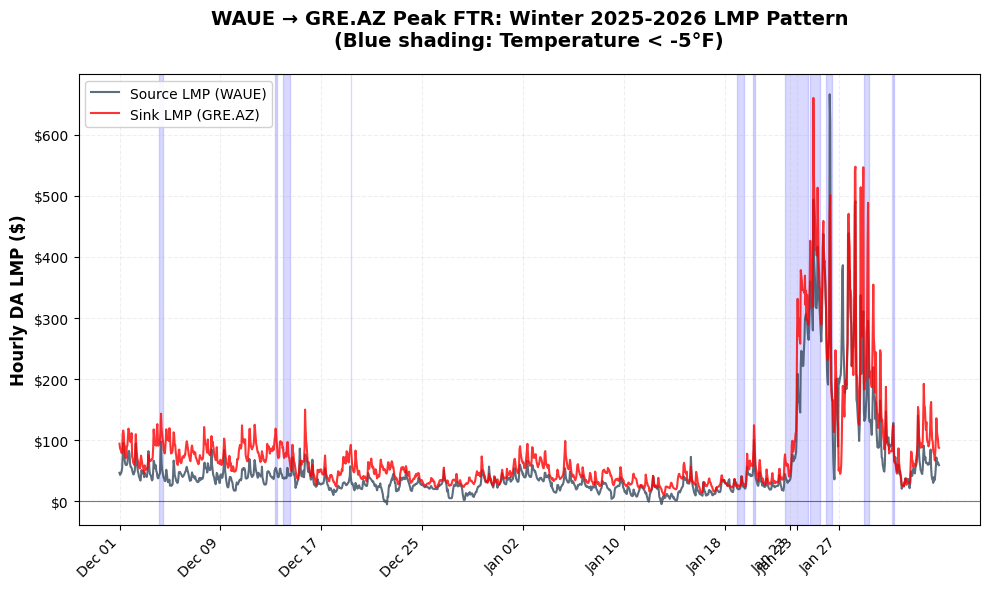

In [23]:
## compare lmps during january 21-26, 2026 cold snap for WAUE and GRE.AZ with waue_gre_ftr data

## Filter data
waue_gre_ftr = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2025)
].sort_values('start_time').copy()

fig, ax1 = plt.subplots(figsize=(10, 6))

## Top panel: Profit/Loss with cold period shading
# First, shade extreme cold regions (temp < -5°F)
cold_mask = waue_gre_ftr['Temperature'] < -5
cold_regions = []
in_cold = False
start_idx = None

for idx, is_cold in enumerate(cold_mask):
    if is_cold and not in_cold:
        start_idx = idx
        in_cold = True
    elif not is_cold and in_cold:
        cold_regions.append((start_idx, idx-1))
        in_cold = False
if in_cold:
    cold_regions.append((start_idx, len(cold_mask)-1))

# Shade cold periods
for start, end in cold_regions:
    ax1.axvspan(waue_gre_ftr.iloc[start]['start_time'], 
                waue_gre_ftr.iloc[end]['start_time'],
                alpha=0.15, color='blue', zorder=0)
# Plot source and sink LMPS
ax1.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['lmp_source'], 
         color='#34495e', 
         linewidth=1.5, 
         alpha=0.8,
         zorder=3)
ax1.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['lmp_sink'],
            color='red',    
            linewidth=1.5, 
            alpha=0.8,
            zorder=3)
## color legend labels
ax1.plot([], [], color='#34495e', linewidth=1.5, alpha=0.8, label='Source LMP (WAUE)')
ax1.plot([], [], color='red', linewidth=1.5, alpha=0.8, label='Sink LMP (GRE.AZ)')
ax1.set_ylabel('Hourly DA LMP ($)', fontsize=12, weight='bold')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.grid(True, alpha=0.2, linestyle='--', zorder=1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.set_title('WAUE → GRE.AZ Peak FTR: Winter 2025-2026 LMP Pattern\n(Blue shading: Temperature < -5°F)', 
              fontsize=14, weight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.9)


## Format x-axis
plt.xticks(rotation=45, ha='right')
n_ticks = 10
tick_spacing = len(waue_gre_ftr) // n_ticks
ax1.set_xticks(waue_gre_ftr['start_time'].iloc[::tick_spacing])
ax1.set_xticklabels([d.strftime('%b %d') for d in waue_gre_ftr['start_time'].iloc[::tick_spacing]])

plt.tight_layout()
plt.show()



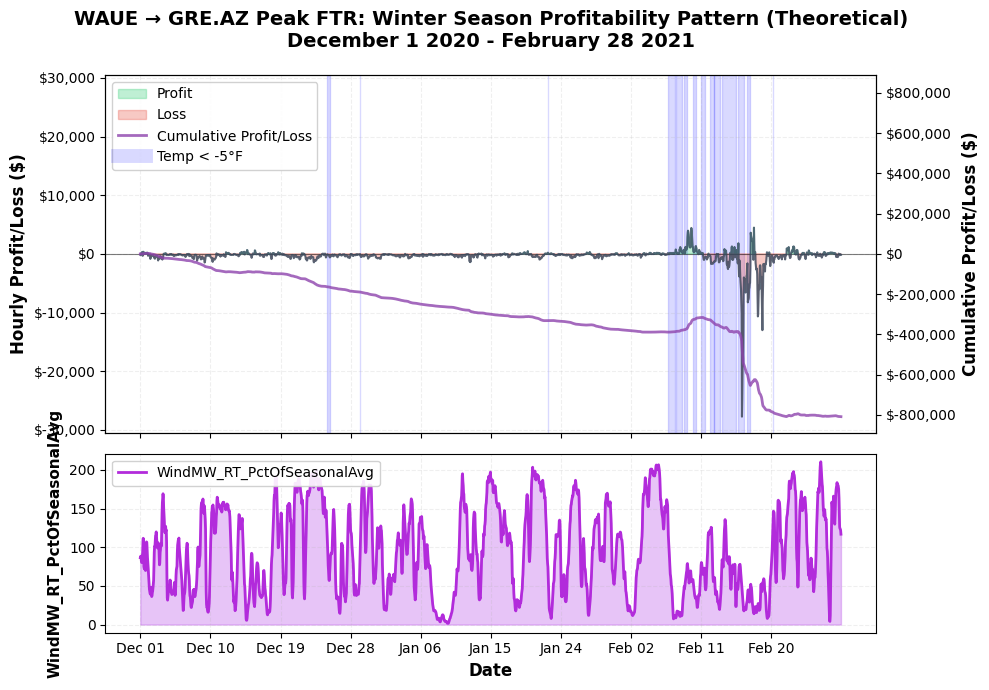


Correlation Analysis:
Temperature vs Profit: 0.170
Wind vs Profit: 0.069

FTR Performance Summary (Jan 21-26, 2026):
Total Profit/Loss: $-808,848.15
Average Hourly: $-374.47
Max Hourly Profit: $4,471.58
Max Hourly Loss: $-27,745.99
Profitable Hours: 423 of 2160

Wind Output:
Average: 95.3% of seasonal average
Min: 1.7%
Max: 210.4%


In [24]:

## Filter data
waue_gre_ftr = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2020)
].sort_values('start_time').copy()

## top plot has left and right y-axes, bottom plot has single y-axis, shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, 
                                gridspec_kw={'height_ratios': [2, 1]})

## Top panel: Profit/Loss with cold period shading
# First, shade extreme cold regions (temp < -5°F)
cold_mask = waue_gre_ftr['Temperature'] < -5
cold_regions = []
in_cold = False
start_idx = None

for idx, is_cold in enumerate(cold_mask):
    if is_cold and not in_cold:
        start_idx = idx
        in_cold = True
    elif not is_cold and in_cold:
        cold_regions.append((start_idx, idx-1))
        in_cold = False
if in_cold:
    cold_regions.append((start_idx, len(cold_mask)-1))

# Shade cold periods
for start, end in cold_regions:
    ax1.axvspan(waue_gre_ftr.iloc[start]['start_time'], 
                waue_gre_ftr.iloc[end]['start_time'],
                alpha=0.15, color='blue', zorder=0)

# Plot profit/loss
ax1.fill_between(waue_gre_ftr['start_time'], 
                  waue_gre_ftr['HourlyProfitLoss'], 
                  0, 
                  where=(waue_gre_ftr['HourlyProfitLoss'] >= 0),
                  color='#2ecc71', alpha=0.3, label='Profit', zorder=2)
ax1.fill_between(waue_gre_ftr['start_time'], 
                  waue_gre_ftr['HourlyProfitLoss'], 
                  0, 
                  where=(waue_gre_ftr['HourlyProfitLoss'] < 0),
                  color='#e74c3c', alpha=0.3, label='Loss', zorder=2)
ax1.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['HourlyProfitLoss'], 
         color='#34495e', 
         linewidth=1.5, 
         alpha=0.8,
         zorder=3)
## left y-axis is centered at 0 with symmetric limits
ax1.set_ylim(-max(abs(waue_gre_ftr['HourlyProfitLoss'].min()), waue_gre_ftr['HourlyProfitLoss'].max()) * 1.1,
             max(abs(waue_gre_ftr['HourlyProfitLoss'].min()), waue_gre_ftr['HourlyProfitLoss'].max()) * 1.1)

## plot cumulative profit/loss on right y-axis
ax3 = ax1.twinx()
ax3.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['HourlyProfitLoss'].cumsum(),
            color='#8e44ad',
            linewidth=2,
            alpha=0.8,
            label='Cumulative Profit/Loss',
            zorder=4)
ax3.set_ylabel('Cumulative Profit/Loss ($)', fontsize=12, weight='bold')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
## right y-axis is centered at 0 
ax3.set_ylim(-max(abs(waue_gre_ftr['HourlyProfitLoss'].cumsum().min()), waue_gre_ftr['HourlyProfitLoss'].cumsum().max()) * 1.1,
             max(abs(waue_gre_ftr['HourlyProfitLoss'].cumsum().min()), waue_gre_ftr['HourlyProfitLoss'].cumsum().max()) * 1.1)
## add cumulative profit/loss to legend
ax1.plot([], [], color='#8e44ad', linewidth=2, alpha=0.8, label='Cumulative Profit/Loss')


## add cold shading to legend
ax1.plot([], [], color='blue', linewidth=10, alpha=0.15, label='Temp < -5°F')

ax1.set_ylabel('Hourly Profit/Loss ($)', fontsize=12, weight='bold')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax1.grid(True, alpha=0.2, linestyle='--', zorder=1)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.set_title('WAUE → GRE.AZ Peak FTR: Winter Season Profitability Pattern (Theoretical)\nDecember 1 2020 - February 28 2021', 
              fontsize=14, weight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.9)

## Bottom panel: WindMW_RT_PctOfSeasonalAvg
ax2.plot(waue_gre_ftr['start_time'], 
         waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'], 
         color="#b22bdb", 
         linewidth=2,
         label='WindMW_RT_PctOfSeasonalAvg')
ax2.fill_between(waue_gre_ftr['start_time'],
                  waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'],
                  alpha=0.3,
                  color="#b13ce7")
ax2.set_ylabel('WindMW_RT_PctOfSeasonalAvg', fontsize=11, weight='bold')
ax2.set_xlabel('Date', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.legend(loc='upper left', framealpha=0.9)

## Format x-axis
plt.xticks(rotation=45, ha='right')
n_ticks = 10
tick_spacing = len(waue_gre_ftr) // n_ticks
ax2.set_xticks(waue_gre_ftr['start_time'].iloc[::tick_spacing])
ax2.set_xticklabels([d.strftime('%b %d') for d in waue_gre_ftr['start_time'].iloc[::tick_spacing]])

plt.tight_layout()
## save figure
plt.savefig(PLOT_DIR / "waue_gre_ftr_pnl_wind_output_winter_2020_v2.png", dpi=300)
plt.show()

## Print temperature correlation
print(f"\nCorrelation Analysis:")
print(f"Temperature vs Profit: {waue_gre_ftr['Temperature'].corr(waue_gre_ftr['HourlyProfitLoss']):.3f}")
print(f"Wind vs Profit: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].corr(waue_gre_ftr['HourlyProfitLoss']):.3f}")
## Print summary statistics
print(f"\nFTR Performance Summary (Jan 21-26, 2026):")
print(f"Total Profit/Loss: ${waue_gre_ftr['HourlyProfitLoss'].sum():,.2f}")
print(f"Average Hourly: ${waue_gre_ftr['HourlyProfitLoss'].mean():,.2f}")
print(f"Max Hourly Profit: ${waue_gre_ftr['HourlyProfitLoss'].max():,.2f}")
print(f"Max Hourly Loss: ${waue_gre_ftr['HourlyProfitLoss'].min():,.2f}")
print(f"Profitable Hours: {(waue_gre_ftr['HourlyProfitLoss'] > 0).sum()} of {len(waue_gre_ftr)}")
print(f"\nWind Output:")
print(f"Average: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].mean():.1f}% of seasonal average")
print(f"Min: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].min():.1f}%")
print(f"Max: {waue_gre_ftr['WindMW_RT_PctOfSeasonalAvg'].max():.1f}%")

In [25]:
## function to calculate conditional value at risk (CVaR) for FTR profitability
def calculate_cvar_pricing(historical_price_spreads, confidence_level=0.99):
    """
    Calculate CVaR for FTR profitability

    Parameters:
    -----------
    historical_price_spreads: Series of historical hourly price spread values for a Source-Sink pair
    confidence_level: Confidence level for CVaR calculation (default 0.99)

    Returns:
    --------
    CVaR value representing the expected loss in the worst (1 - confidence_level)% of cases
    """

    ## extract spreads
    spreads = historical_price_spreads['PriceSpread'].values

    ## Step 1: ID tail events based on confidence level
    ## get thresholds for left / right tails
    left_tail_threshold = np.percentile(spreads, (1 - confidence_level) * 100) # worst 1% if confidence_level=0.99
    right_tail_threshold = np.percentile(spreads, 100 - (1 - confidence_level) * 100) # best 1% if confidence_level=0.99

    ## extract left and right tail events
    left_tail_events = spreads[spreads <= left_tail_threshold]
    right_tail_events = spreads[spreads >= right_tail_threshold] 
    
    ## Step 2: Calculate CVaR for left and right tails
    cvar_left = left_tail_events.mean() if len(left_tail_events) > 0 else 0
    cvar_right = right_tail_events.mean() if len(right_tail_events) > 0 else 0

    ## Step 3: Calculate overall statistics
    mean_spread = spreads.mean()
    median_spread = np.median(spreads)
    std_spread = spreads.std()
    skewness_spread = stats.skew(spreads, bias=False)
    kurtosis_spread = stats.kurtosis(spreads, bias=False)

    ## Step 4: Calculate expected spread under CVaR scenario
    alpha = 1 - confidence_level
    ## calculate weighted average of mean and left tail CVaR for "conservative" estimate
    expected_spread_cvar = alpha * cvar_left + (1 - alpha) * mean_spread

    return {
        "Mean_Spread": mean_spread,
        "Median_Spread": median_spread,
        "Std_Spread": std_spread,
        "Skewness_Spread": skewness_spread,
        "Kurtosis_Spread": kurtosis_spread,
        "CVaR_Value": expected_spread_cvar,
        "CVaR_Left_Tail": cvar_left,
        "CVaR_Right_Tail": cvar_right,
        "Left_Tail_Threshold": left_tail_threshold,
        "Right_Tail_Threshold": right_tail_threshold,
        "n_observations": len(spreads),
        "n_left_tail_events": len(left_tail_events),
        "n_right_tail_events": len(right_tail_events)
    }

## function to calculate CVaR pricing given CVaR metrics, MW, hours
def calculate_cvar_ftr_price(cvar_metrics, mw, hours):
    """
    Calculate CVaR-based FTR price

    Parameters:
    -----------
    cvar_metrics: Dictionary of CVaR metrics from calculate_cvar_pricing function
    mw: MW quantity of the FTR
    hours: Number of hours the FTR covers

    Returns:
    --------
    CVaR-based FTR price representing the expected cost under extreme price spread scenarios
    """
    ## extract CVaR value (expected spread under worst-case scenario)
    expected_spread_cvar = cvar_metrics['CVaR_Value']

    ## calculate CVaR-based price as expected spread times MW and hours
    cvar_ftr_price = expected_spread_cvar * mw * hours

    ## calculate a risk premium as the difference between CVaR-based price and mean spread price
    mean_spread_price = cvar_metrics['Mean_Spread'] * mw * hours
    risk_premium = cvar_ftr_price - mean_spread_price

    return {
        "CVaR_FTR_Price": cvar_ftr_price,
        "Mean_Spread_Price": mean_spread_price,
        "Risk_Premium": risk_premium
    }


In [26]:
## calculate CVaR for WAUE-GRE.AZ price spreads leading up to Uri (WinterYear = 2020)
waue_gre_historical = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] < 2020) &
    (detailed_ftr_df['Class'] == 'Peak') &
    (detailed_ftr_df['PriceSpread'].notna())
]

## extract price spreads for CVaR calculation
waue_gre_spreads = waue_gre_historical[['PriceSpread']]

## calculate CVaR metrics
cvar_metrics = calculate_cvar_pricing(waue_gre_spreads, confidence_level=0.95)
print("CVaR Metrics for WAUE-GRE.AZ Price Spreads (Pre-Uri):")
for key, value in cvar_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

## calculate CVaR-based FTR price for a hypothetical 77 MW 1008-hour Peak FTR
cvar_ftr_price = calculate_cvar_ftr_price(cvar_metrics, mw=77, hours=1008)
print("\nCVaR-Based FTR Price Calculation for 77 MW, 1008 hours:")
for key, value in cvar_ftr_price.items():
    if isinstance(value, float):
        print(f"{key}: ${value:,.2f}")
    else:
        print(f"{key}: {value}")

CVaR Metrics for WAUE-GRE.AZ Price Spreads (Pre-Uri):
Mean_Spread: 1.9611
Median_Spread: 1.5550
Std_Spread: 5.9967
Skewness_Spread: -1.6319
Kurtosis_Spread: 157.4955
CVaR_Value: 1.3997
CVaR_Left_Tail: -9.2674
CVaR_Right_Tail: 16.4140
Left_Tail_Threshold: -4.5200
Right_Tail_Threshold: 8.9750
n_observations: 5856
n_left_tail_events: 293
n_right_tail_events: 293

CVaR-Based FTR Price Calculation for 77 MW, 1008 hours:
CVaR_FTR_Price: $108,637.75
Mean_Spread_Price: $152,213.51
Risk_Premium: $-43,575.76


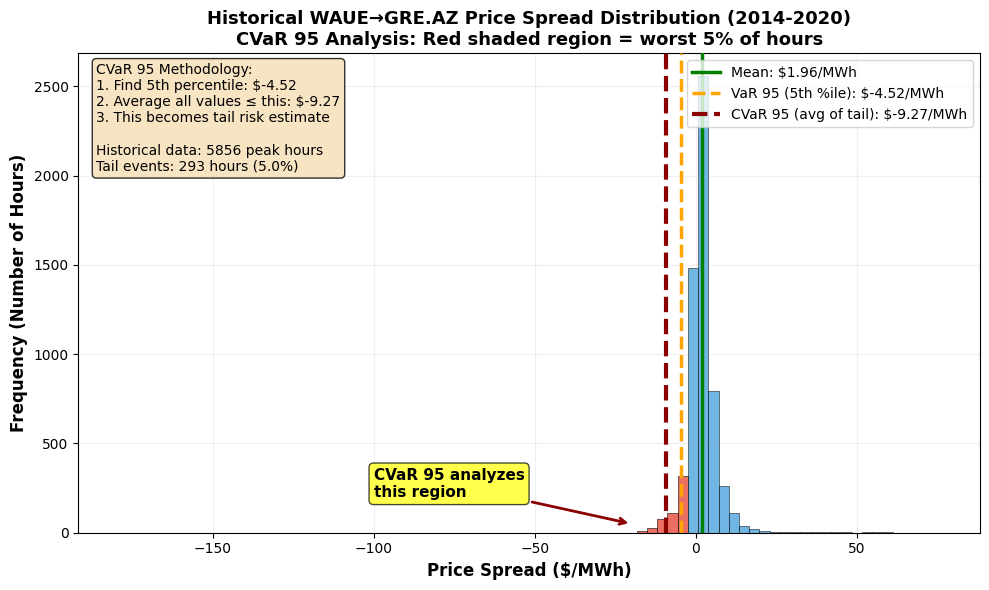

CVaR 95 Calculation from Historical Data (2014-2020)

Distribution Statistics:
  Mean: $1.96/MWh
  Median: $1.55/MWh
  Std Dev: $6.00/MWh
  Skewness: -1.631
  Kurtosis: 157.360

CVaR 95 Metrics:
  VaR 95 threshold: $-4.52/MWh
  Number of tail events: 293 hours
  Percentage in tail: 5.00%
  CVaR 95 (tail average): $-9.27/MWh

Normal Distribution Comparison:
  If data were normal, VaR 95 would be: $-7.90/MWh
  Actual VaR 95: $-4.52/MWh
  Difference: $3.38/MWh
  (Negative skew makes tail worse than normal predicts)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Use ACTUAL historical spreads (not synthetic)
historical_spreads = waue_gre_historical['PriceSpread'].values

## Calculate CVaR metrics
var_95 = np.percentile(historical_spreads, 5)  # 5th percentile threshold
cvar_95 = historical_spreads[historical_spreads <= var_95].mean()  # Average of tail

mean_spread = historical_spreads.mean()
std_spread = historical_spreads.std()

## Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

## Histogram of ACTUAL historical data
counts, bins, patches = ax.hist(historical_spreads, bins=80, 
                                color='#3498db', alpha=0.7, 
                                edgecolor='black', linewidth=0.5)

## Shade the 5% left tail region (the CVaR region)
for i, patch in enumerate(patches):
    if bins[i] <= var_95:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.8)

## Add vertical lines for key values
ax.axvline(mean_spread, color='green', linestyle='-', linewidth=2.5,
          label=f'Mean: ${mean_spread:.2f}/MWh', zorder=5)

ax.axvline(var_95, color='orange', linestyle='--', linewidth=2.5,
          label=f'VaR 95 (5th %ile): ${var_95:.2f}/MWh', zorder=5)

ax.axvline(cvar_95, color='darkred', linestyle='--', linewidth=3,
          label=f'CVaR 95 (avg of tail): ${cvar_95:.2f}/MWh', zorder=5)


## Add text annotation explaining CVaR
ax.text(0.02, 0.98, 
        'CVaR 95 Methodology:\n'
        f'1. Find 5th percentile: ${var_95:.2f}\n'
        f'2. Average all values ≤ this: ${cvar_95:.2f}\n'
        f'3. This becomes tail risk estimate\n\n'
        f'Historical data: {len(historical_spreads)} peak hours\n'
        f'Tail events: {(historical_spreads <= var_95).sum()} hours ({(historical_spreads <= var_95).mean()*100:.1f}%)',
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('Price Spread ($/MWh)', fontsize=12, weight='bold')
ax.set_ylabel('Frequency (Number of Hours)', fontsize=12, weight='bold')
ax.set_title('Historical WAUE→GRE.AZ Price Spread Distribution (2014-2020)\n'
             'CVaR 95 Analysis: Red shaded region = worst 5% of hours',
             fontsize=13, weight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.2)
ax.set_xlim(historical_spreads.min() * 1.1, historical_spreads.max() * 1.1)

# tail annotation with arrow
ax.annotate('CVaR 95 analyzes\nthis region',
            xy=(-20, 50),
            xytext=(-100, 200),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
            fontsize=11, weight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))


plt.tight_layout()
plt.savefig(PLOT_DIR / "historical_cvar_methodology.png", dpi=300, bbox_inches='tight')
plt.show()

## Print statistics
print("="*70)
print("CVaR 95 Calculation from Historical Data (2014-2020)")
print("="*70)
print(f"\nDistribution Statistics:")
print(f"  Mean: ${mean_spread:.2f}/MWh")
print(f"  Median: ${np.median(historical_spreads):.2f}/MWh")
print(f"  Std Dev: ${std_spread:.2f}/MWh")
print(f"  Skewness: {stats.skew(historical_spreads):.3f}")
print(f"  Kurtosis: {stats.kurtosis(historical_spreads):.3f}")

print(f"\nCVaR 95 Metrics:")
print(f"  VaR 95 threshold: ${var_95:.2f}/MWh")
print(f"  Number of tail events: {(historical_spreads <= var_95).sum()} hours")
print(f"  Percentage in tail: {(historical_spreads <= var_95).mean()*100:.2f}%")
print(f"  CVaR 95 (tail average): ${cvar_95:.2f}/MWh")

print(f"\nNormal Distribution Comparison:")
normal_var95 = stats.norm.ppf(0.05, mean_spread, std_spread)
print(f"  If data were normal, VaR 95 would be: ${normal_var95:.2f}/MWh")
print(f"  Actual VaR 95: ${var_95:.2f}/MWh")
print(f"  Difference: ${var_95 - normal_var95:.2f}/MWh")
print(f"  (Negative skew makes tail worse than normal predicts)")


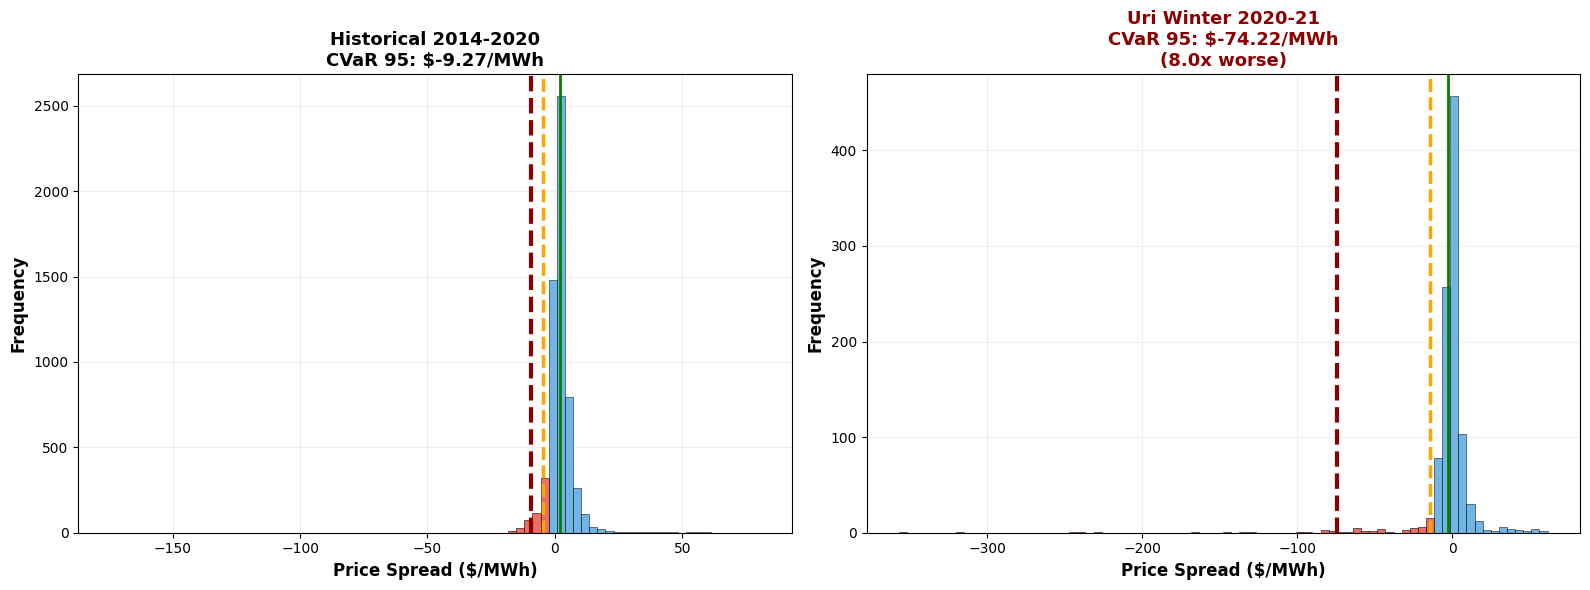

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

## LEFT: Historical CVaR
counts1, bins1, patches1 = ax1.hist(historical_spreads, bins=80,
                                     color='#3498db', alpha=0.7,
                                     edgecolor='black', linewidth=0.5)
for i, patch in enumerate(patches1):
    if bins1[i] <= hist_var95:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.8)

ax1.axvline(hist_mean, color='green', linestyle='-', linewidth=2)
ax1.axvline(hist_var95, color='orange', linestyle='--', linewidth=2.5)
ax1.axvline(hist_cvar95, color='darkred', linestyle='--', linewidth=3)
ax1.set_title(f'Historical 2014-2020\nCVaR 95: ${hist_cvar95:.2f}/MWh',
             fontsize=13, weight='bold')

## RIGHT: Uri Reality
counts2, bins2, patches2 = ax2.hist(uri_spreads, bins=80,
                                     color='#3498db', alpha=0.7,
                                     edgecolor='black', linewidth=0.5)
for i, patch in enumerate(patches2):
    if bins2[i] <= uri_var95:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.8)

ax2.axvline(uri_mean, color='green', linestyle='-', linewidth=2)
ax2.axvline(uri_var95, color='orange', linestyle='--', linewidth=2.5)
ax2.axvline(uri_cvar95, color='darkred', linestyle='--', linewidth=3)
ax2.set_title(f'Uri Winter 2020-21\nCVaR 95: ${uri_cvar95:.2f}/MWh\n(8.0x worse)',
             fontsize=13, weight='bold', color='darkred')

# Both axes same labels and scales for comparison
for ax in [ax1, ax2]:
    ax.set_xlabel('Price Spread ($/MWh)', fontsize=12, weight='bold')
    ax.set_ylabel('Frequency', fontsize=12, weight='bold')
    ax.grid(True, alpha=0.2)

## save figure
plt.tight_layout()
plt.savefig(PLOT_DIR / "cvar_historical_vs_uri_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


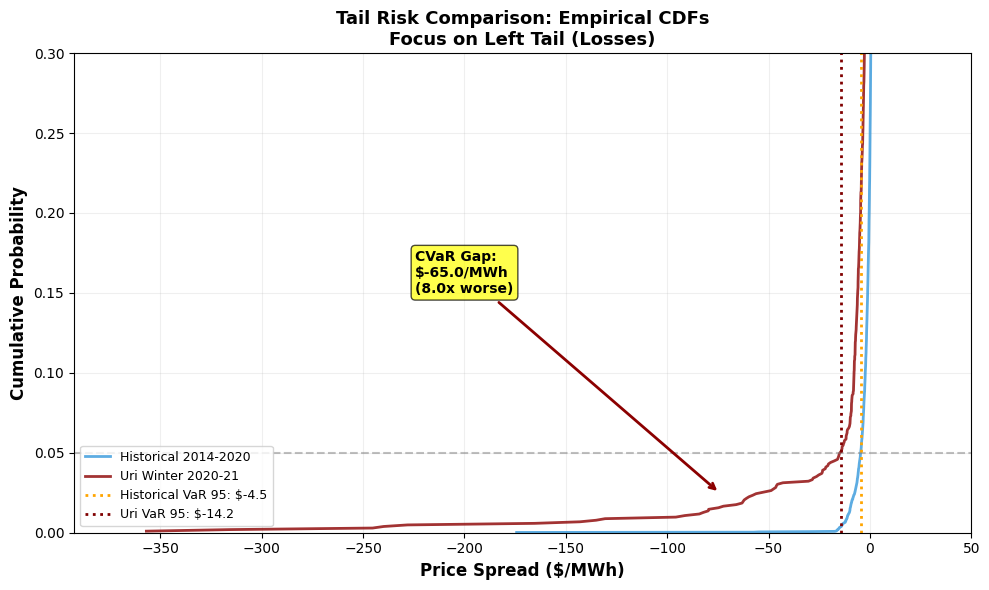

Distribution Comparison: Historical (2014-2020) vs Uri (2020-21)

Central Tendency:
  Historical Mean: $1.96/MWh
  Uri Mean: $-2.75/MWh
  Shift: $-4.71/MWh (-240.4%)
  Historical Median: $1.55/MWh
  Uri Median: $0.05/MWh

Tail Risk (5% VaR):
  Historical VaR 95: $-4.52/MWh
  Uri VaR 95: $-14.21/MWh
  Deterioration: 3.1x worse

Tail Severity (5% CVaR):
  Historical CVaR 95: $-9.27/MWh
  Uri CVaR 95: $-74.22/MWh
  Deterioration: 8.0x worse
  % of Uri events worse than Historical CVaR 95: 7.5%

Extreme Values:
  Historical Worst: $-174.25/MWh
  Uri Worst: $-356.88/MWh
  Ratio: 2.0x worse

Distribution Shape:
  Historical Skewness: -1.631
  Uri Skewness: -7.925
  Historical Kurtosis: 157.360
  Uri Kurtosis: 86.443

Profit/Loss Comparison for 77 MW, 1008-hour Peak FTR:
  Actual Profit/Loss during Uri: $-218,852,282.88
  CVaR-Based Expected Profit/Loss: $108,637.75
  Mean-Based Expected Profit/Loss: $152,213.51
  CVaR vs Actual: $218,960,920.63 difference
  Mean vs Actual: $219,004,496.39 di

In [44]:
## CVaR pricing to Uri comparison for WAUE-GRE.AZ Peak FTR
uri_period = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2020) &
    (detailed_ftr_df['Class'] == 'Peak') &
    (detailed_ftr_df['PriceSpread'].notna())
]
## Historical distribution used for CVaR calculation
waue_gre_historical = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] < 2020) &
    (detailed_ftr_df['Class'] == 'Peak') &
    (detailed_ftr_df['PriceSpread'].notna())
]
historical_spreads = waue_gre_historical['PriceSpread'].values
uri_spreads = uri_period['PriceSpread'].values

## key statistics
hist_mean = historical_spreads.mean()
hist_var95 = np.percentile(historical_spreads, 5)
hist_cvar95 = historical_spreads[historical_spreads <= hist_var95].mean()

uri_mean = uri_spreads.mean()
uri_var95 = np.percentile(uri_spreads, 5)
uri_cvar95 = uri_spreads[uri_spreads <= uri_var95].mean()

## Setup
fig, ax2 = plt.subplots(figsize=(10, 6))

## Tail Comparison (Empirical CDFs)
## Sort data
hist_sorted = np.sort(historical_spreads)
uri_sorted = np.sort(uri_spreads)

## Calculate empirical CDFs
hist_cdf = np.arange(1, len(hist_sorted) + 1) / len(hist_sorted)
uri_cdf = np.arange(1, len(uri_sorted) + 1) / len(uri_sorted)

## Plot focusing on left tail
ax2.plot(hist_sorted, hist_cdf, color='#3498db', linewidth=2, 
         label='Historical 2014-2020', alpha=0.8)
ax2.plot(uri_sorted, uri_cdf, color='darkred', linewidth=2,
         label='Uri Winter 2020-21', alpha=0.8)

## Highlight the 5% tail region
ax2.axhline(0.05, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.axvline(hist_var95, color='orange', linestyle=':', linewidth=2,
            label=f'Historical VaR 95: ${hist_var95:.1f}')
ax2.axvline(uri_var95, color='maroon', linestyle=':', linewidth=2,
            label=f'Uri VaR 95: ${uri_var95:.1f}')

## Add text annotations showing the gap
gap = uri_cvar95 - hist_cvar95
ax2.annotate(f'CVaR Gap:\n${gap:.1f}/MWh\n({abs(uri_cvar95/hist_cvar95):.1f}x worse)',
             xy=(uri_cvar95, 0.025),
             xytext=(uri_cvar95 - 150, 0.15),
             fontsize=10,
             weight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

ax2.set_xlabel('Price Spread ($/MWh)', fontsize=12, weight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=12, weight='bold')
ax2.set_title('Tail Risk Comparison: Empirical CDFs\nFocus on Left Tail (Losses)', 
              fontsize=13, weight='bold')
ax2.legend(fontsize=9, loc='lower left')
ax2.grid(True, alpha=0.2)
ax2.set_xlim(min(uri_spreads.min(), historical_spreads.min()) * 1.1, 50)
ax2.set_ylim(0, 0.3)  # Focus on tail region

plt.tight_layout()
plt.savefig(PLOT_DIR / "waue_gre_ftr_cvar_uri_tail.png", dpi=300, bbox_inches='tight')
plt.show()

## Print comparison statistics
print("="*70)
print("Distribution Comparison: Historical (2014-2020) vs Uri (2020-21)")
print("="*70)
print(f"\nCentral Tendency:")
print(f"  Historical Mean: ${hist_mean:.2f}/MWh")
print(f"  Uri Mean: ${uri_mean:.2f}/MWh")
print(f"  Shift: ${uri_mean - hist_mean:.2f}/MWh ({(uri_mean/hist_mean - 1)*100:+.1f}%)")
hist_median = np.median(historical_spreads)
print(f"  Historical Median: ${hist_median:.2f}/MWh")
uri_median = np.median(uri_spreads)
print(f"  Uri Median: ${uri_median:.2f}/MWh")

print(f"\nTail Risk (5% VaR):")
print(f"  Historical VaR 95: ${hist_var95:.2f}/MWh")
print(f"  Uri VaR 95: ${uri_var95:.2f}/MWh")
print(f"  Deterioration: {abs(uri_var95/hist_var95):.1f}x worse")

print(f"\nTail Severity (5% CVaR):")
print(f"  Historical CVaR 95: ${hist_cvar95:.2f}/MWh")
print(f"  Uri CVaR 95: ${uri_cvar95:.2f}/MWh")
print(f"  Deterioration: {abs(uri_cvar95/hist_cvar95):.1f}x worse")
## % of Uri events exceeding historical 95% CVaR
uri_exceeding_cvar = (uri_spreads <= hist_cvar95).mean()
print(f"  % of Uri events worse than Historical CVaR 95: {uri_exceeding_cvar*100:.1f}%")

print(f"\nExtreme Values:")
print(f"  Historical Worst: ${historical_spreads.min():.2f}/MWh")
print(f"  Uri Worst: ${uri_spreads.min():.2f}/MWh")
print(f"  Ratio: {abs(uri_spreads.min()/historical_spreads.min()):.1f}x worse")

print(f"\nDistribution Shape:")
print(f"  Historical Skewness: {stats.skew(historical_spreads):.3f}")
print(f"  Uri Skewness: {stats.skew(uri_spreads):.3f}")
print(f"  Historical Kurtosis: {stats.kurtosis(historical_spreads):.3f}")
print(f"  Uri Kurtosis: {stats.kurtosis(uri_spreads):.3f}")

## profit loss for FTR using CVaR-based pricing vs actual performance during Uri
## hypothetical FTR details
ftr_mw = 77
ftr_hours = 1008
cvar_price = cvar_ftr_price['CVaR_FTR_Price']
mean_price = cvar_ftr_price['Mean_Spread_Price']
## actual profit/loss during Uri
uri_profit_loss = uri_spreads * ftr_mw * ftr_hours
## CVaR-based profit/loss
cvar_profit_loss = cvar_price
mean_profit_loss = mean_price
print("\nProfit/Loss Comparison for 77 MW, 1008-hour Peak FTR:")
print(f"  Actual Profit/Loss during Uri: ${uri_profit_loss.sum():,.2f}")
print(f"  CVaR-Based Expected Profit/Loss: ${cvar_profit_loss:,.2f}")
print(f"  Mean-Based Expected Profit/Loss: ${mean_profit_loss:,.2f}")
print(f"  CVaR vs Actual: ${cvar_profit_loss - uri_profit_loss.sum():,.2f} difference")
print(f"  Mean vs Actual: ${mean_profit_loss - uri_profit_loss.sum():,.2f} difference")


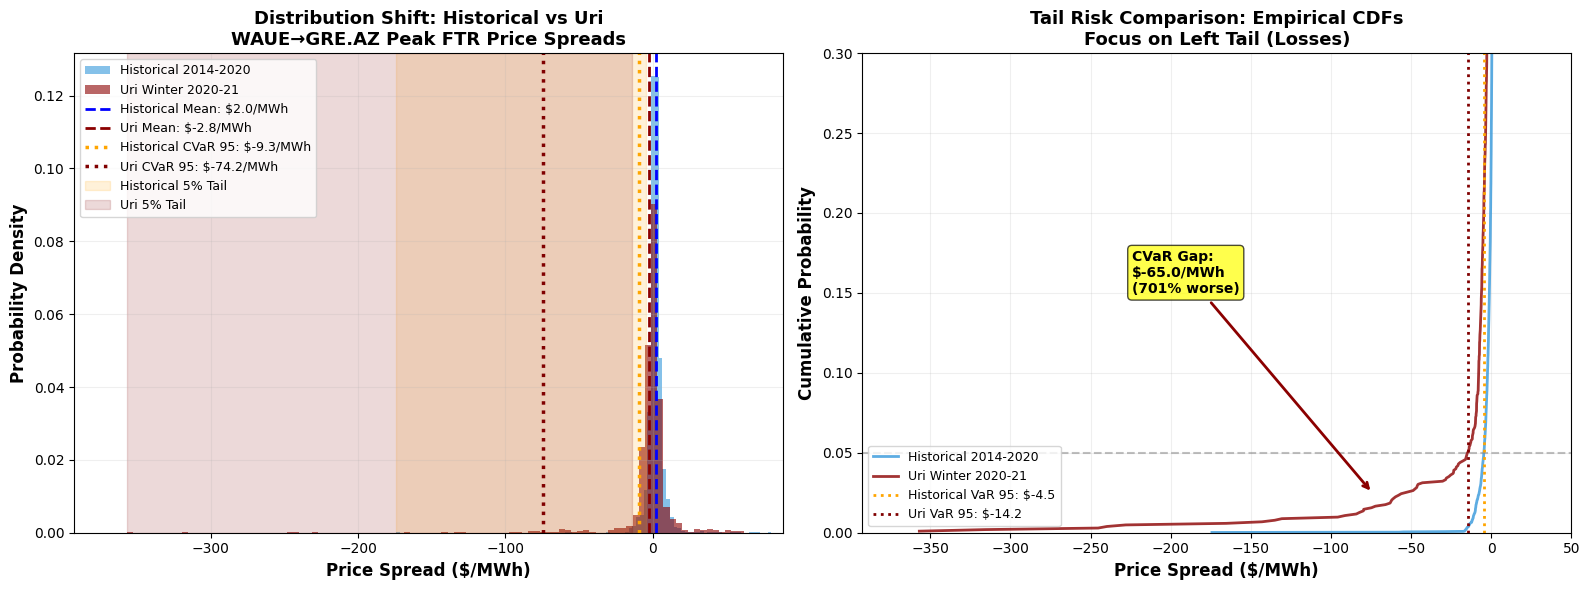

Distribution Comparison: Historical (2014-2020) vs Uri (2020-21)

Central Tendency:
  Historical Mean: $1.96/MWh
  Uri Mean: $-2.75/MWh
  Shift: $-4.71/MWh (-240.4%)
  Historical Median: $1.55/MWh
  Uri Median: $0.05/MWh

Tail Risk (5% VaR):
  Historical VaR 95: $-4.52/MWh
  Uri VaR 95: $-14.21/MWh
  Deterioration: 3.1x worse

Tail Severity (5% CVaR):
  Historical CVaR 95: $-9.27/MWh
  Uri CVaR 95: $-74.22/MWh
  Deterioration: 8.0x worse
  % of Uri events worse than Historical CVaR 95: 7.5%

Extreme Values:
  Historical Worst: $-174.25/MWh
  Uri Worst: $-356.88/MWh
  Ratio: 2.0x worse

Distribution Shape:
  Historical Skewness: -1.631
  Uri Skewness: -7.925
  Historical Kurtosis: 157.360
  Uri Kurtosis: 86.443

Profit/Loss Comparison for 77 MW, 1008-hour Peak FTR:
  Actual Profit/Loss during Uri: $-218,852,282.88
  CVaR-Based Expected Profit/Loss: $108,637.75
  Mean-Based Expected Profit/Loss: $152,213.51
  CVaR vs Actual: $218,960,920.63 difference
  Mean vs Actual: $219,004,496.39 di

In [27]:
## CVaR pricing to Uri comparison for WAUE-GRE.AZ Peak FTR
uri_period = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2020) &
    (detailed_ftr_df['Class'] == 'Peak') &
    (detailed_ftr_df['PriceSpread'].notna())
]
## Historical distribution used for CVaR calculation
waue_gre_historical = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] < 2020) &
    (detailed_ftr_df['Class'] == 'Peak') &
    (detailed_ftr_df['PriceSpread'].notna())
]
historical_spreads = waue_gre_historical['PriceSpread'].values
uri_spreads = uri_period['PriceSpread'].values

## Setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

## LEFT PLOT: Overlayed Distributions
## Historical distribution
ax1.hist(historical_spreads, bins=100, color='#3498db', alpha=0.6, 
         density=True, label='Historical 2014-2020')

## Uri distribution overlayed
ax1.hist(uri_spreads, bins=100, color='darkred', alpha=0.6, 
         density=True, label='Uri Winter 2020-21')

## Mark key statistics
hist_mean = historical_spreads.mean()
hist_var95 = np.percentile(historical_spreads, 5)
hist_cvar95 = historical_spreads[historical_spreads <= hist_var95].mean()

uri_mean = uri_spreads.mean()
uri_var95 = np.percentile(uri_spreads, 5)
uri_cvar95 = uri_spreads[uri_spreads <= uri_var95].mean()

## Add vertical lines for comparison
ax1.axvline(hist_mean, color='blue', linestyle='--', linewidth=2, 
            label=f'Historical Mean: ${hist_mean:.1f}/MWh')
ax1.axvline(uri_mean, color='darkred', linestyle='--', linewidth=2,
            label=f'Uri Mean: ${uri_mean:.1f}/MWh')

ax1.axvline(hist_cvar95, color='orange', linestyle=':', linewidth=2.5,
            label=f'Historical CVaR 95: ${hist_cvar95:.1f}/MWh')
ax1.axvline(uri_cvar95, color='maroon', linestyle=':', linewidth=2.5,
            label=f'Uri CVaR 95: ${uri_cvar95:.1f}/MWh')

## Shade the tail regions for impact
ax1.axvspan(hist_var95, historical_spreads.min(), alpha=0.15, color='orange',
            label='Historical 5% Tail')
ax1.axvspan(uri_var95, uri_spreads.min(), alpha=0.15, color='maroon',
            label='Uri 5% Tail')

ax1.set_xlabel('Price Spread ($/MWh)', fontsize=12, weight='bold')
ax1.set_ylabel('Probability Density', fontsize=12, weight='bold')
ax1.set_title('Distribution Shift: Historical vs Uri\nWAUE→GRE.AZ Peak FTR Price Spreads', 
              fontsize=13, weight='bold')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.2)
ax1.set_xlim(min(uri_spreads.min(), historical_spreads.min()) * 1.1, 
             max(uri_spreads.max(), historical_spreads.max()) * 1.1)

## RIGHT PLOT: Tail Comparison (Empirical CDFs)
## Sort data
hist_sorted = np.sort(historical_spreads)
uri_sorted = np.sort(uri_spreads)

## Calculate empirical CDFs
hist_cdf = np.arange(1, len(hist_sorted) + 1) / len(hist_sorted)
uri_cdf = np.arange(1, len(uri_sorted) + 1) / len(uri_sorted)

## Plot focusing on left tail
ax2.plot(hist_sorted, hist_cdf, color='#3498db', linewidth=2, 
         label='Historical 2014-2020', alpha=0.8)
ax2.plot(uri_sorted, uri_cdf, color='darkred', linewidth=2,
         label='Uri Winter 2020-21', alpha=0.8)

## Highlight the 5% tail region
ax2.axhline(0.05, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.axvline(hist_var95, color='orange', linestyle=':', linewidth=2,
            label=f'Historical VaR 95: ${hist_var95:.1f}')
ax2.axvline(uri_var95, color='maroon', linestyle=':', linewidth=2,
            label=f'Uri VaR 95: ${uri_var95:.1f}')

## Add text annotations showing the gap
gap = uri_cvar95 - hist_cvar95
ax2.annotate(f'CVaR Gap:\n${gap:.1f}/MWh\n({abs(gap/hist_cvar95)*100:.0f}% worse)',
             xy=(uri_cvar95, 0.025),
             xytext=(uri_cvar95 - 150, 0.15),
             fontsize=10,
             weight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

ax2.set_xlabel('Price Spread ($/MWh)', fontsize=12, weight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=12, weight='bold')
ax2.set_title('Tail Risk Comparison: Empirical CDFs\nFocus on Left Tail (Losses)', 
              fontsize=13, weight='bold')
ax2.legend(fontsize=9, loc='lower left')
ax2.grid(True, alpha=0.2)
ax2.set_xlim(min(uri_spreads.min(), historical_spreads.min()) * 1.1, 50)
ax2.set_ylim(0, 0.3)  # Focus on tail region

plt.tight_layout()
plt.savefig(PLOT_DIR / "waue_gre_ftr_cvar_uri_comparison_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

## Print comparison statistics
print("="*70)
print("Distribution Comparison: Historical (2014-2020) vs Uri (2020-21)")
print("="*70)
print(f"\nCentral Tendency:")
print(f"  Historical Mean: ${hist_mean:.2f}/MWh")
print(f"  Uri Mean: ${uri_mean:.2f}/MWh")
print(f"  Shift: ${uri_mean - hist_mean:.2f}/MWh ({(uri_mean/hist_mean - 1)*100:+.1f}%)")
hist_median = np.median(historical_spreads)
print(f"  Historical Median: ${hist_median:.2f}/MWh")
uri_median = np.median(uri_spreads)
print(f"  Uri Median: ${uri_median:.2f}/MWh")

print(f"\nTail Risk (5% VaR):")
print(f"  Historical VaR 95: ${hist_var95:.2f}/MWh")
print(f"  Uri VaR 95: ${uri_var95:.2f}/MWh")
print(f"  Deterioration: {abs(uri_var95/hist_var95):.1f}x worse")

print(f"\nTail Severity (5% CVaR):")
print(f"  Historical CVaR 95: ${hist_cvar95:.2f}/MWh")
print(f"  Uri CVaR 95: ${uri_cvar95:.2f}/MWh")
print(f"  Deterioration: {abs(uri_cvar95/hist_cvar95):.1f}x worse")
## % of Uri events exceeding historical 95% CVaR
uri_exceeding_cvar = (uri_spreads <= hist_cvar95).mean()
print(f"  % of Uri events worse than Historical CVaR 95: {uri_exceeding_cvar*100:.1f}%")

print(f"\nExtreme Values:")
print(f"  Historical Worst: ${historical_spreads.min():.2f}/MWh")
print(f"  Uri Worst: ${uri_spreads.min():.2f}/MWh")
print(f"  Ratio: {abs(uri_spreads.min()/historical_spreads.min()):.1f}x worse")

print(f"\nDistribution Shape:")
print(f"  Historical Skewness: {stats.skew(historical_spreads):.3f}")
print(f"  Uri Skewness: {stats.skew(uri_spreads):.3f}")
print(f"  Historical Kurtosis: {stats.kurtosis(historical_spreads):.3f}")
print(f"  Uri Kurtosis: {stats.kurtosis(uri_spreads):.3f}")

## profit loss for FTR using CVaR-based pricing vs actual performance during Uri
## hypothetical FTR details
ftr_mw = 77
ftr_hours = 1008
cvar_price = cvar_ftr_price['CVaR_FTR_Price']
mean_price = cvar_ftr_price['Mean_Spread_Price']
## actual profit/loss during Uri
uri_profit_loss = uri_spreads * ftr_mw * ftr_hours
## CVaR-based profit/loss
cvar_profit_loss = cvar_price
mean_profit_loss = mean_price
print("\nProfit/Loss Comparison for 77 MW, 1008-hour Peak FTR:")
print(f"  Actual Profit/Loss during Uri: ${uri_profit_loss.sum():,.2f}")
print(f"  CVaR-Based Expected Profit/Loss: ${cvar_profit_loss:,.2f}")
print(f"  Mean-Based Expected Profit/Loss: ${mean_profit_loss:,.2f}")
print(f"  CVaR vs Actual: ${cvar_profit_loss - uri_profit_loss.sum():,.2f} difference")
print(f"  Mean vs Actual: ${mean_profit_loss - uri_profit_loss.sum():,.2f} difference")


In [28]:
## get temperatures during uri period just to see how extreme they were
uri_temperatures = detailed_ftr_df[
    (detailed_ftr_df['Source'] == 'WAUE') & 
    (detailed_ftr_df['Sink'] == 'GRE.AZ') & 
    (detailed_ftr_df['WinterYear'] == 2020) &
    (detailed_ftr_df['Class'] == 'Peak')
]['Temperature']
print("\nTemperature Statistics during Uri Winter 2020-21:")
print(f"  Average Temperature: {uri_temperatures.mean():.1f}°F")
print(f"  Minimum Temperature: {uri_temperatures.min():.1f}°F")
print(f"  Maximum Temperature: {uri_temperatures.max():.1f}°F")



Temperature Statistics during Uri Winter 2020-21:
  Average Temperature: 20.3°F
  Minimum Temperature: -27.5°F
  Maximum Temperature: 46.8°F
